### Machine Learning Demo - Forecasting of UK Month Ahead Electricity Prices

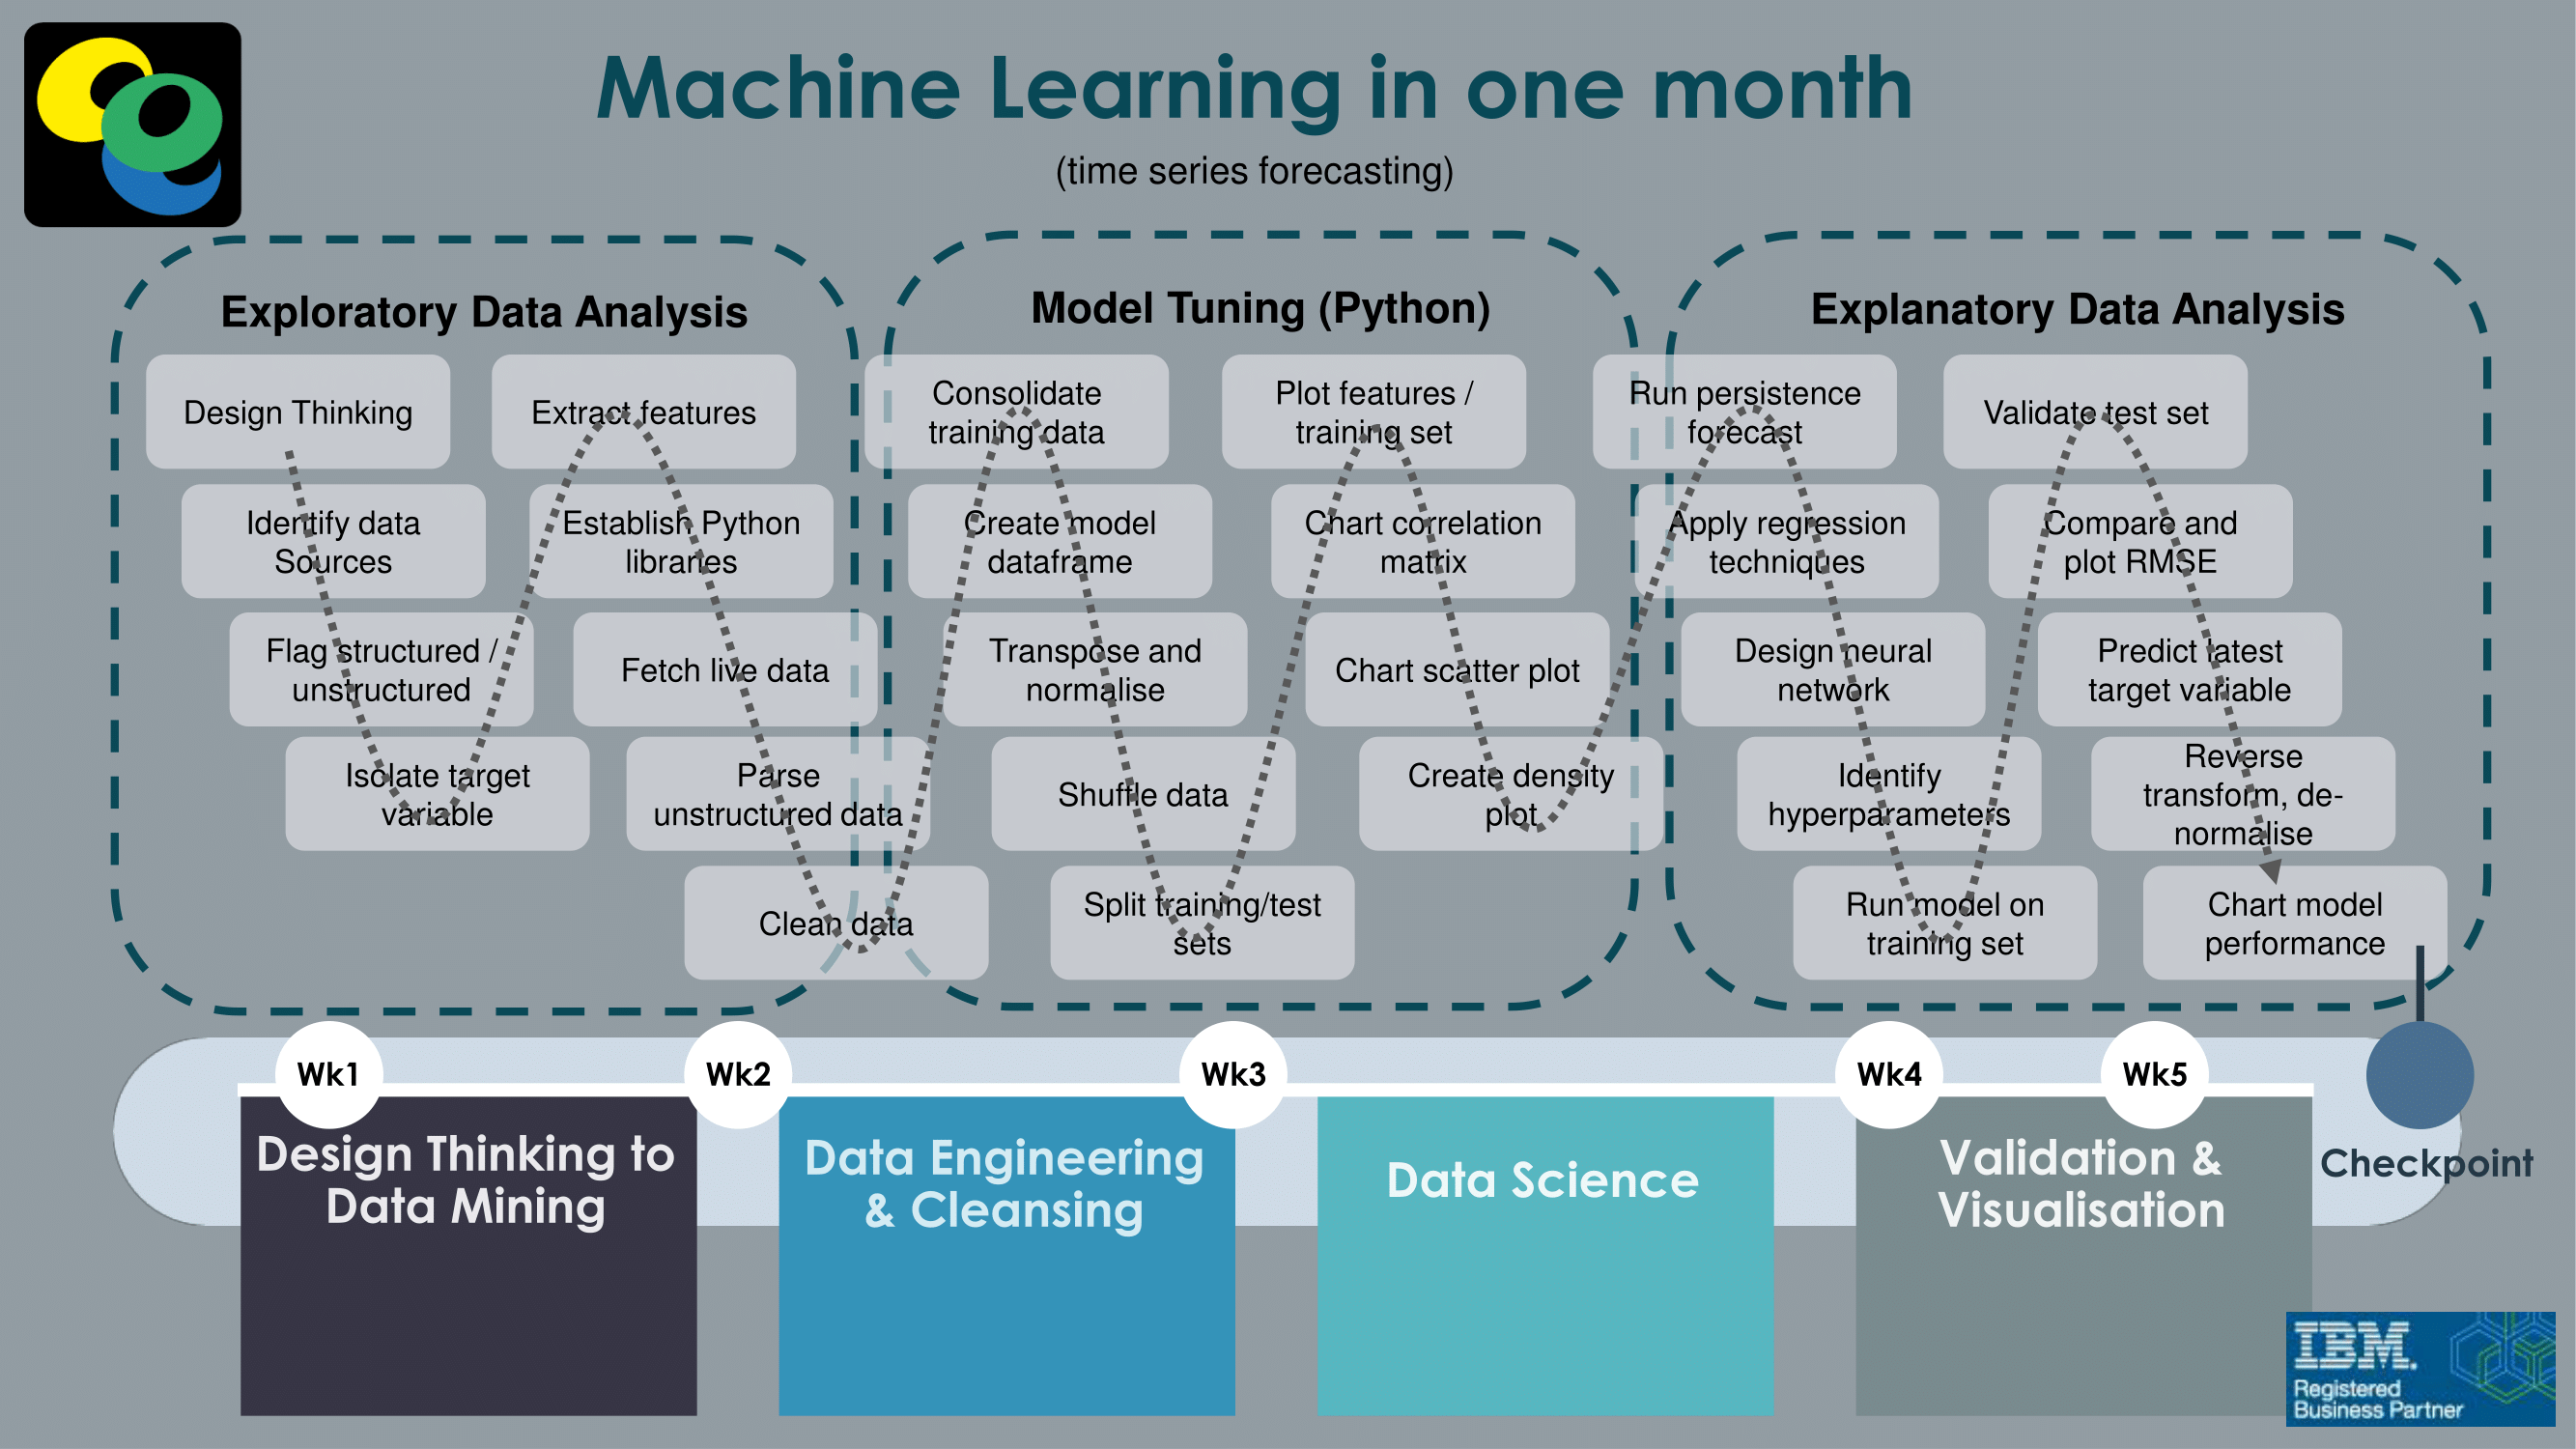

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename="1monthAI.png" ,width=800,height=600)

## Model Process
### Scrape data
- [GetWeather](#Weather)
- [GetDemand](#Demand)
- [GetWindSolar](#RES)
- [GetFX](#FX)
- [GetPrices](#Prices)


- [CreateNeuralNetwork](#RNN)
- [TrainingDataPlot](#TrainingPlot)
- [CreateLSTMKeras](#CreateLSTM)
- [RunPersistence](#Persistence)
- [Run LSTM](#RunLSTM)

--- [SubMenu1](#SubMenu1)
--- [SubMenu2](#SubMenu2)

- [Plot Training Subplots](#TrainingSubplots)
- [CorrelationMatrix](#Correlation)
- [ScatterPlot](#Scatter)
- [UnivariateDensity Plot](#Density)
- [Actual v Forecast](#ActualvForecast)
- [Push2Plotly](#Plotly)


<a id='Weather'></a>
### Get Weather

In [2]:
#FULL DATA MINE AND CLEAN UP

#def getWeather():
import requests # library for html requests
from datetime import date # library for python date formats? *check*

#get weather
#set up daily link
weather_fcast = "http://www.metoffice.gov.uk/public/weather/forecast/gcpvj0v07"
#send url requests to data links
weather_fcast_rqst = requests.get(weather_fcast)
#convert web data to text strings
weather_fcast_text = weather_fcast_rqst.text
#for testing 
print(weather_fcast_text)

#def cleanWeather():
#clean weather
import numpy as np

weather_short = []

weather_date = weather_fcast_text.index('data-tab-id') #finds 1st date tabs within text string (should be today)
weather_fcast_chopped = weather_fcast_text #intialise weather dataframe

#counter for remaining days in week
days = 1
while days <= 7:

    weather_date_short=weather_fcast_chopped[weather_date+13:weather_date+23]

    #chop off the head of text string, find the max 
    weather_fcast_chopped = weather_fcast_chopped[weather_date:len(weather_fcast_chopped)]
    #check line below the search criteria 'Maximum daytime temperature: ' often changes on MetOffice website
    #in the past this has been 'Maximum daytime temperature. ' or 'Maximum daytime temperature .'
    weather_max = weather_fcast_chopped.index('Maximum daytime temperature: ') #finds temp max within text string

    #find number of decimal places for max temp
    chr_adder=29
    while weather_fcast_chopped[weather_max+chr_adder] != '&':
        if chr_adder == 33:
            break
        chr_adder += 1

    weather_max_short=weather_fcast_chopped[weather_max+29:weather_max+chr_adder]

    #chop off the head of text string, find the min 
    weather_fcast_chopped = weather_fcast_chopped[weather_max+1:len(weather_fcast_chopped)]
    #check line below the search criteria 'Minimum nighttime temperature: ' often changes on MetOffice website
    #in the past this has been 'Minimum nighttime temperature. ' or 'Minimum nighttime temperature .'
    weather_min = weather_fcast_chopped.index('Minimum nighttime temperature: ') #finds temp min within text string

    #find number of decimal places for max temp
    chr_adder=31
    while weather_fcast_chopped[weather_min+chr_adder] != '&':
        if chr_adder == 34:
            break
        chr_adder += 1

    weather_min_short=weather_fcast_chopped[weather_min+31:weather_min+chr_adder]

    #gather list data
    weather_short.append(days)
    weather_short[days-1]=[weather_date_short,weather_max_short,weather_min_short]

    #search the next occurence of the forecast date
    weather_fcast_chopped = weather_fcast_chopped[weather_min:len(weather_fcast_chopped)]
    if days < 7:
        weather_date = weather_fcast_chopped.index('data-tab-id') #finds next date tabs within text string

    days += 1

#convert weather_short from list of lists to numpy array
weather_short = np.array(weather_short)

<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="utf-8"/>
<meta http-equiv="X-UA-Compatible" content="IE=Edge">
<meta name="viewport" content="initial-scale=1.0, width=device-width, viewport-fit=cover">

<meta name="eGMS.accessibility" content="A" />
<meta name="eGMS.subject.category" content="Climate and weather" />

<meta name="twitter:site" content="@metoffice" />
<meta name="twitter:card" content="summary" />
<meta name="twitter:url" content="https://www.metoffice.gov.uk/weather/forecast/gcpvj0v07" />

<meta property="fb:app_id" content="208580322593329" />
<meta property="og:site_name" content="Met Office" />

<meta property="og:type" content="website" />
<meta property="og:url" content="https://www.metoffice.gov.uk/weather/forecast/gcpvj0v07" />

<meta name="theme-color" content="#2a2a2a"/>

<meta property="og:image" content="https://www.metoffice.gov.uk/webfiles/1572349202202/images/icons/social-icons/default_card_315.jpg" />
<meta property="twitter:image" content="https:/

In [3]:
#quick check of array asdataframe

import pandas as pd
pd.DataFrame(weather_short,columns=["Forecast Date","MaxTemp","MinTemp"]).head()

,Forecast Date,MaxTemp,MinTemp
0,2019-11-11,9,4
1,2019-11-12,8,5
2,2019-11-13,9,5
3,2019-11-14,7,4
4,2019-11-15,8,6


<a id='Demand'></a>
### Get Demand

In [ ]:
#get demand
data = pd.read_csv('https://api.bmreports.com/BMRS/FORDAYDEM/v1?APIKey=lg3cgfi7sanoqzm&ServiceType=csv', skiprows=[0])
print(data)

#clean demand

import datetime

data.columns = ['Demand Fcast Type', 'Date','Settlement Period','N Flag','Time of Fcast?', 'Demand MW']
load_fcast_text=data.filter(items=['Date','Settlement Period','Demand MW','Demand Fcast Type'])
load_fcast_text=load_fcast_text.loc[load_fcast_text['Demand Fcast Type'] == "DATF"]
load_fcast_text.set_index('Date')
print(load_fcast_text.dtypes)
load_fcast_text['Date'] = pd.to_datetime(load_fcast_text['Date'],format='%Y%m%d')

#convert load_fcast_text from list of lists to numpy array
load_fcast_text = np.array(load_fcast_text)
#print(load_fcast_text)

load_fcast_text_D=load_fcast_text[load_fcast_text[:,0] < datetime.datetime.now()]
load_fcast_text_D1=load_fcast_text[load_fcast_text[:,0] > datetime.datetime.now()]

print(load_fcast_text_D1)
#load_fcast_text_D+1

#print(load_fcast_text[:,2])
np.mean(load_fcast_text_D1[:,2])

In [ ]:
#quick check of array asdataframe

pd.DataFrame(load_fcast_text,columns=["Date","Settlement Period","Demand MW","Demand Fcast Type"]).head()

In [ ]:
#also tail of forecast

pd.DataFrame(load_fcast_text,columns=["Date","Settlement Period","Demand MW","Demand Fcast Type"]).tail()

<a id='RES'></a>
### Get Wind/Solar

In [ ]:
#get RES
#NB skiprows below will skip number of rows specified and infer number of columns of data from the next row
#NB use str(date.today() + datetime.timedelta(1)) for tomorrow 
RES_data = pd.read_csv('https://api.bmreports.com/BMRS/B1440/v1?ServiceType=csv&Period=*&APIKey=lg3cgfi7sanoqzm&SettlementDate=' + str(date.today()), skiprows=4)
print(RES_data)
#USE THIS TO JUST PRINT ONE ROW: print(data.loc[1]) NB INDEXING STARTS FROM ROW ZERO WHICH IS FIRST ROW OF DATA (HEADER DOESNT COUNT)
#USE THIS TO JUST PRINT ONE VALUE WITHIN A ROW: print(data.iloc[1][5])

#clean RES
RES_fcast_text = RES_data[0:-1] #remove last row NaN
#no need to get column names, as these were imported with csv
RES_fcast_text=RES_fcast_text.filter(items=['Settlement Date','Settlement Period','Quantity','Business Type','Power System Resource  Type'])
RES_fcast_text.set_index('Settlement Date') #may have to combine this later with settlement period
RES_fcast_text=RES_fcast_text.sort_values(by='Settlement Period')
RES_fcast_text=RES_fcast_text.reset_index(drop=True)
print(RES_fcast_text.dtypes)
#RES_fcast_text['Settlement Date'] = pd.to_datetime(RES_fcast_text['Settlement Date'],format='%Y%m%d')

#convert RES_fcast_text from list of lists to numpy array
RES_fcast_text = np.array(RES_fcast_text)

#print(RES_fcast_text)
print(RES_fcast_text[RES_fcast_text[:,0] == str(date.today())])

In [ ]:
#quick look at dataframe

pd.DataFrame(RES_fcast_text,columns=['Settlement Date','Settlement Period','Quantity','Business Type','Power System Resource  Type']).head()

In [ ]:
#also tail of forecast

pd.DataFrame(RES_fcast_text,columns=['Settlement Date','Settlement Period','Quantity','Business Type','Power System Resource  Type']).tail()

<a id='FX'></a>
### Get FX

In [ ]:
#get FX

import requests
FX = "https://www.poundsterlinglive.com/data/currencies/gbp-pairs/GBPEUR-exchange-rate"
FX_fcast_rqst = requests.get(FX)
print(FX_fcast_rqst) # should say 200 means connection is good
FX_fcast_text = FX_fcast_rqst.text
#print(FX_fcast_text)

#truncate data pulled back, from today's price
#first find "Today’s Price":
FX_GBPEUR = FX_fcast_text.index('Latest GBP/EUR') #find "Today’s Price" within data
#print(FX_EURGBP)
FX_GBPEUR_chopped=FX_fcast_text[FX_GBPEUR:len(FX_fcast_text)]

print(FX_GBPEUR_chopped)

#repeat for GBPUSD
FX = "https://www.poundsterlinglive.com/data/currencies/gbp-pairs/GBPUSD-exchange-rate"
FX_fcast_rqst = requests.get(FX)
print(FX_fcast_rqst) # should say 200 means connection is good
FX_fcast_text = FX_fcast_rqst.text
#print(FX_fcast_text)

#truncate data pulled back, from today's price
#first find "Today’s Price":
FX_GBPUSD = FX_fcast_text.index('Latest GBP/USD') #find "Today’s Price" within data

#print(FX_GBPUSD)
FX_GBPUSD_chopped=FX_fcast_text[FX_GBPUSD:len(FX_fcast_text)]

print(FX_GBPUSD_chopped)

#clean FX

FX_short = {}

FX_short[0,0]="GBPEUR"
FX_short[0,1]=FX_GBPEUR_chopped[45:51]
#NB can also store last 5, 10, 15, 20,50,100 days averages and % changes - later

FX_short[1,0]="GBPUSD"
FX_short[1,1]=FX_GBPUSD_chopped[45:51]

print(FX_short)
print(FX_short[0,1])
print(FX_short[1,1])

In [ ]:
#quick look at output *check* change later to dataframe

FX_short

<a id='Prices'></a>
### Get Gas/Elec Prices

In [ ]:
#get elec and gas prices
import pandas as pd
Marex_data = pd.read_csv('http://www.marexspectron.com/intelligence/indices/historical-index')
print(Marex_data)

#clean elec prices

#no need to get column names, as these were imported with csv
Marex_fcast_text=Marex_data.filter(items=['DealDate','Average','High','Low','IndexName','InstrumentName','SequenceItemName','MarketName'])
Marex_fcast_text.set_index('DealDate') 
#filter by elec baseload then by D-1
Marex_fcast_text=Marex_fcast_text.loc[(Marex_fcast_text['IndexName'] == "U.K Power BSLD All-Day D.A") | (Marex_fcast_text['IndexName'] == "U.K Power BSLD All-Day M.A") | (Marex_fcast_text['IndexName'] == "NBP All Day D.A") | (Marex_fcast_text['IndexName'] == "NBP All Day M.A") ]

Marex_fcast_text['DealDate'] = pd.to_datetime(Marex_fcast_text['DealDate'],format='%d/%m/%Y')

if date.today()==datetime.date(2018, 8, 28): #bank holiday exceptions - make more robust at a later stage
  Marex_fcast_text=Marex_fcast_text.loc[Marex_fcast_text['DealDate'] == date.today()- datetime.timedelta(4)]
elif date.today().weekday() == 0: #Monday
  Marex_fcast_text=Marex_fcast_text.loc[Marex_fcast_text['DealDate'] == date.today()- datetime.timedelta(3)] # NEED TO USE date.today()- timedelta(1))
else: #Tue, Wed, Thu or Fri. BASICALLY DONT RUN WEEKEND
  Marex_fcast_text=Marex_fcast_text.loc[Marex_fcast_text['DealDate'] == date.today()- datetime.timedelta(1)] # NEED TO USE date.today()- timedelta(1))

Marex_fcast_text=Marex_fcast_text.reset_index(drop=True) #reset index to 0

print(Marex_fcast_text.dtypes)
#RES_fcast_text['Settlement Date'] = pd.to_datetime(RES_fcast_text['Settlement Date'],format='%Y%m%d')

print(Marex_fcast_text)

Marex_fcast_text = np.array(Marex_fcast_text)

print(Marex_fcast_text)

#some error handling in case Marex prices not in datafeed (this has happened before on 23 Apr 2019)
import sys

if Marex_fcast_text[:1,1]=='.':
    print("No DA NBP price in Marex Spectron datafeed")
    sys.exit(0)
if Marex_fcast_text[1:2,1]=='.':
    print("No MA NBP price in Marex Spectron datafeed")
    sys.exit(0)
if Marex_fcast_text[2:3,1]=='.':
    print("No DA elec price in Marex Spectron datafeed")
    sys.exit(0)
if Marex_fcast_text[3:4,1]=='.':
    print("No MA elec price in Marex Spectron datafeed")
    sys.exit(0)

In [ ]:
#quick look at dataframe

pd.DataFrame(Marex_fcast_text,columns=['DealDate','Average','High','Low','IndexName','InstrumentName','SequenceItemName','MarketName'])

<a id='RNN'></a>
### Create Neural Network

In [ ]:
#create neural network (live) input (i.e. test) and output (for valiation) matrices 

import numpy as np
import pandas as pd
import datetime

nn_input=0

#nn_input = np.array() #initialise

#nn=weather_short[0:2,1] #add weather highs
# print(weather_short[0:2,1])
# print(weather_short[0:2,2])
nn_input=np.concatenate((weather_short[:1,1], weather_short[:1,2])) #add high, weather low D NEEDS TWO BRACKETS (( ))
nn_input=np.concatenate((nn_input, weather_short[1:2,1])) #add high D+1
nn_input=np.concatenate((nn_input, weather_short[1:2,2])) #add low D+1
#nn_input stands for neural network and is input matrix, basically values for:

#WeatherHigh_D
#WeatherLow_D
#WeatherHigh_D+1
#WeatherLow_D+1
#Av Demand D
#Peak Demand D
#Av Demand D+1
#Peak Demand D+1
#Av Offshore Wind D
#Peak Offshore Wind D
#Av Onshore Wind D
#Peak Onshore Wind D
#Av Solar D
#Peak Solar D
#GBPEUR rate
#GBBUSD rate
#DA NBP 
#MA NBP

#add demand facast
nn_input=np.hstack((nn_input,round(np.mean(load_fcast_text_D[:,2]),2)))
nn_input=np.hstack((nn_input,round(np.max(load_fcast_text_D[:,2]),2)))
nn_input=np.hstack((nn_input,round(np.mean(load_fcast_text_D1[:,2]),2)))
nn_input=np.hstack((nn_input,round(np.max(load_fcast_text_D1[:,2]),2)))

#add RES fcast
#RES_fcast_D=RES_fcast_text[RES_fcast_text[:,0] == str(date.today())])

RES_fcast_D= RES_fcast_text[RES_fcast_text[:,0] == str(date.today())]
OFFwind_fcast_D=RES_fcast_D[RES_fcast_D[:,4] == 'Wind Offshore']
ONwind_fcast_D=RES_fcast_D[RES_fcast_D[:,4] == 'Wind Onshore']
SolarPV_fcast_D=RES_fcast_D[RES_fcast_D[:,4] == 'Solar']
nn_input=np.hstack((nn_input,round(np.mean(OFFwind_fcast_D[:,2]),2)))
nn_input=np.hstack((nn_input,round(np.max(OFFwind_fcast_D[:,2]),2)))
nn_input=np.hstack((nn_input,round(np.mean(ONwind_fcast_D[:,2]),2)))
nn_input=np.hstack((nn_input,round(np.max(ONwind_fcast_D[:,2]),2)))
nn_input=np.hstack((nn_input,round(np.mean(SolarPV_fcast_D[:,2]),2)))
nn_input=np.hstack((nn_input,round(np.max(SolarPV_fcast_D[:,2]),2)))

#print(RES_fcast_D)
#load_fcast_text[load_fcast_text[:,0] < datetime.datetime.now()]

#add FX fcast
nn_input=np.hstack((nn_input,FX_short[0,1])) #GBPEUR
nn_input=np.hstack((nn_input,FX_short[1,1])) #GBPUSD

#add NBP prices
nn_input=np.hstack((nn_input,Marex_fcast_text[:1,1])) #DA NBP
nn_input=np.hstack((nn_input,Marex_fcast_text[1:2,1])) #MA NBP

#add Marex elec prices
nn_input=np.hstack((nn_input,Marex_fcast_text[2:3,1])) #DA elec
nn_input=np.hstack((nn_input,Marex_fcast_text[3:4,1])) #MA elec

#create nn_output (predictor is Marex elec price)
#NB need to update later - this is the target, so the forecast is not "known" until D+a
#nn_output=np.concatenate((Marex_fcast_text[2:3,1], Marex_fcast_text[3:4,1]))
#nn_output stands for neural network and is output (target) matrix, basically values for:

#DA elec
#MA elec

#nn_input=np.asarray(np.mean(load_fcast_text_D[:,2]))
print(nn_input)
#print(nn_output)

#np.savetxt('C:\ChangingEnergy\Beta_testing\ML testing\RollingTrainingData.csv', nn_input, fmt='%s', delimiter=',', header="WeatherHigh_D,WeatherLow_D,WeatherHigh_D+1,WeatherLow_D+1,Av Demand D,Peak Demand D,Av Demand D+1,Peak Demand D+1,Av Offshore Wind D,Peak Offshore Wind D,Av Onshore Wind D,Peak Onshore Wind D,Av Solar D,Peak Solar D,GBPEUR rate,GBBUSD rate,DA NBP,MA NBP")

#convert neural network input to pandas data frame
nn_input=pd.DataFrame(nn_input,columns = [str(date.today())])
print(str(date.today()))
nn_input=nn_input.T #transpose array for csv export

#USE TWO LINES BELOW ONCE THIS IS UP AND RUNNING TO APPEND DATA
with open("RollingTrainingData.csv", 'a') as rolling_training_data:
    nn_input.to_csv(rolling_training_data,header=False, index=True)
print(rolling_training_data)

training_data=np.array(rolling_training_data) #turn training_data pandas dataframe into numpy array for NN algo
print(training_data)

<a id='TrainingPlot'></a>
### Training Data Plot

In [ ]:
#plot training data as time series plots
#see for help: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

from pandas import read_csv
from matplotlib import pyplot
import matplotlib.pyplot as plt

#input('Starting python')

# load dataset
dataset = read_csv('RollingTrainingData.csv', header=0, index_col=0)
values = dataset.values

#BELOW PLOTS MOVED TO END OF SCRIPT
# specify columns to plot
# groups = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
# i = 1
# # plot each column
# pyplot.figure(0)
# # pyplot.figure(figsize=(8,20)) # have to comment out for running python shell as will cause an error trying to fit plot to window
# for group in groups:  
# 	pyplot.subplot(len(groups), 1, i) #subplot(nrows, ncols, index, **kwargs)
# 	pyplot.plot(values[:, group])
# 	pyplot.title(dataset.columns[group], y=-0.05, loc='right')
# 	i += 1
# pyplot.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=1, wspace=0.2, hspace=0.1)
# pyplot.show()


# data.columns=names #rename columns with short name to make scatter plot easier to read

#taken from https://stackoverflow.com/questions/29432629/correlation-matrix-using-pandas
#pyplot.figure(1)
#pyplot.matshow(dataset.corr())
#pyplot.show() #required to show plot when running python shell

#input('End of code')

<a id='CreateLSTM'></a>
### Create LSTM with Keras

In [ ]:
#Multivariate Time Series Forecasting with LSTMs in Keras

import numpy as np
import math

from math import sqrt
from fractions import gcd #greatest common divisor to work out optimal number of batches given sizes of training and test sets
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

<a id='Persistence'></a>
### Run Persistence Forecast

In [ ]:
#FIRST RUN PERSISTENCE MODEL

# load dataset
series = read_csv('RollingTrainingData.csv', header=0, index_col=0)

# split data into train and test
X = series.values
n_train_days = math.floor(len(X)*0.8) #use 80/20 rule train on 80% of data, test on 20%
train = X[:n_train_days, -1] 
test = X[n_train_days:, -1] 

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# make prediction
	predictions.append(history[-1])
	# observation
	history.append(test[i])
# report performance
rmse_persistence = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse_persistence)
# line plot of observed vs predicted
pyplot.plot(test)
pyplot.plot(predictions)
pyplot.show()

<a id='RunLSTM'></a>
### Run LSTM Model

In [ ]:
#NOW RUN LSTM Model

# load dataset
dataset = read_csv('RollingTrainingData.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4]) #assigns ordinal levels to categorical data - this is for label data dont need in our case

In [ ]:
    # ensure all data is float
values = values.astype('float32')
#print(values)
#print("BREAK")
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled)

In [ ]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict - this is basically all columns for predictor variables at t+1 (next time step)
reframed.drop(reframed.columns[[20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38]], axis=1, inplace=True)

In [ ]:
# split into train and test sets
values = reframed.values
n_train_days = math.floor(len(values)*0.8) #use 80/20 rule train on 80% of data, test on 20%
np.random.shuffle(values) #shuffling data to remove trend (will randomly assign test data and training data rather than take 
#e.g. first 80 days to train on and last 20 days to test on - if its a rising market this is likely to underfit)
train = values[:n_train_days, :] 
test = values[n_train_days:, :] 
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1] #stick with MA elec for now, later expand to DA and MA if code scalable
test_X, test_y = test[:, :-1], test[:, -1] #stick with MA elec for now, later expand to DA and MA if code scalable

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
print(train_X)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [ ]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network #check batch size should be big really (assuming big data sourced). 
#In our case its still a small growing dataset, example used batch size 72 and epochs 50
history = model.fit(train_X, train_y, epochs=50, batch_size=gcd(len(train_X),len(test_X)), validation_data=(test_X, test_y), verbose=2, shuffle=False)

In [ ]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.savefig('ML_Demo_TrainTestPlot.png')
pyplot.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((test_X[:, :-1],yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

In [ ]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, :-1],test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print(inv_y,inv_yhat)
print('Test RMSE: %.3f' % rmse)

In [ ]:
#write comparison of RMSE for LSTM model and Persistence Model to csv

RMSE_comparison=concatenate(([rmse_persistence],[rmse]), axis=0)

#convert forecast to pandas data frame
latest_rmse=pd.DataFrame(RMSE_comparison,columns = [str(date.today())])
print(str(date.today()))
print(latest_rmse)
latest_rmse=latest_rmse.T #transpose array for csv export

with open('ModelComparison.csv', 'a') as model_comparison:
    latest_rmse.to_csv(model_comparison,header=False, index=True)

In [ ]:
#latest predictor dataset only
import datetime
import numpy as np
import pandas as pd

#first read existing forecast v. actual file to get deltas
forecast_comparison = pd.read_csv('Elec_MA_fcast.csv',index_col=[0])
#forecast_comparison.set_index("Date", drop = False)

forecast_comparison=np.array(forecast_comparison) #turn training_data pandas dataframe into numpy array for NN algo

In [ ]:
#get latest deltas
latest_actual_delta= [float(Marex_fcast_text[3:4,1]) - forecast_comparison[len(forecast_comparison)-1,0]] #latest actual delta
latest_fcast_delta=[forecast_comparison[len(forecast_comparison)-1,1] - forecast_comparison[len(forecast_comparison)-2,1]] #latest forecast delta

latest_data= series_to_supervised(scaled, 0, 1) #no time increment for last row of predictor variables as forecast is "unknown"
values=latest_data.values
latest_X=values[len(values)-1:, :]
print(latest_X.shape)
print(latest_X[:,-1].shape)

In [ ]:
#reshape input to be 3D [samples, timesteps, features]
latest_X = latest_X.reshape((latest_X.shape[0], 1, latest_X.shape[1]))
print(latest_X.shape)
# latest_X
# latest_X = latest_X.reshape((latest_X.shape[0], latest_X.shape[2]))
# latest_X=scaler.inverse_transform(latest_X)
# latest_X


# make a prediction
latest_hat = model.predict(latest_X)

In [ ]:
#get ready to transform back
latest_X = latest_X.reshape((latest_X.shape[0], latest_X.shape[2]))
# invert scaling for forecast
inv_latest_hat = concatenate((latest_X[:, :-1],latest_hat), axis=1)
inv_latest_hat = scaler.inverse_transform(inv_latest_hat)
print(inv_latest_hat) #check this should be the latest predictor varables (20) minus last elec MA price plus a single forecasted MA price at end of array
inv_latest_hat = inv_latest_hat[:,-1]

In [ ]:
#export latest forecast to csv

latest_forecast=concatenate((Marex_fcast_text[3:4,1],inv_latest_hat,latest_actual_delta,latest_fcast_delta), axis=0)

print(Marex_fcast_text[3:4,1])
print(latest_forecast)
#convert forecast to pandas data frame
latest_forecast=pd.DataFrame(latest_forecast,columns = [str(date.today())])
print(str(date.today()))
print(latest_forecast)
latest_forecast=latest_forecast.T #transpose array for csv export

In [ ]:
with open('Elec_MA_fcast.csv', 'a') as rolling_forecast:
    latest_forecast.to_csv(rolling_forecast,header=False, index=True)

<a id='TrainingSubplots'></a>
### Plot Training Subplots

In [ ]:
#additional plots

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas
import numpy
from pandas.plotting import scatter_matrix

In [ ]:
# Training data subplots

dataset = read_csv('RollingTrainingData.csv')

dataset = dataset.rename(columns={'Unnamed: 0': 'Date'}) #rename date column
# forecast_comparison.index = forecast_comparison["Date"] #set date column as index - needed to show date as x axis in charts below
# forecast_comparison=forecast_comparison.drop(['Date'], axis=1)

dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.set_index(['Date'],inplace=True)

dataset.plot(kind='line', subplots=True, layout=(5,4),sharex=True,figsize=(13,13))

plt.savefig('ML_Demo_TrainingData.png')
plt.show()

<a id='Correlation'></a>
### Correlation Matrix

In [ ]:
# Correlation Matrix Plot 

#source https://machinelearningmastery.com/visualize-machine-learning-data-python-pandas/

url = "RollingTrainingData.csv"
names = ["THighD","TLowD","THighD+1","TLowD+1","AvDD","PkDD","AvDD+1","PkDD+1","AvOffD","PkOffD","AvOnD","PkOnD","AvPVD","PkPVD","GBPEUR","GBBUSD","NBPDA","NBPMA","ElecDA","ElecMA"]

data = pandas.read_csv(url)
data = data.drop(data.columns[0], axis=1)
data.columns=names #rename columns with short name to make plots easier to read

#names = ["WeatherHigh_D","WeatherLow_D","WeatherHigh_D+1","WeatherLow_D+1","Av Demand D","Peak Demand D","Av Demand D+1","Peak Demand D+1","Av Offshore Wind D","Peak Offshore Wind D","Av Onshore Wind D","Peak Onshore Wind D","Av Solar D","Peak Solar D","GBPEUR rate","GBBUSD rate","DA NBP","MA NBP","DA Elec","MA Elec"]
#data = pandas.read_csv(url, names=names)
correlations = data.corr()
# plot correlation matrix
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = numpy.arange(0,20,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
plt.xticks(rotation=90)
ax.set_yticklabels(names)
plt.savefig('ML_Demo_CorrelationMatrix.png')
plt.show()

<a id='Scatter'></a>
### Scatter Plot

In [ ]:
# Scatterplot Matrix

#some of below taken from https://stackoverflow.com/questions/32560932/how-to-customize-a-scatter-matrix-to-see-all-titles

from pandas.plotting import scatter_matrix

sm=scatter_matrix(data,figsize=(13,13))

#Change label rotation
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

#May need to offset label when rotating to prevent overlap of figure
[s.get_yaxis().set_label_coords(-0.8,0.5) for s in sm.reshape(-1)]

#Hide all ticks
[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]

plt.savefig('ML_Demo_ScatterPlots.png')
plt.show()

<a id='Density'></a>
### Univariate Density Plot

In [ ]:

# Univariate Density Plots

data.plot(kind='density', subplots=True, layout=(5,4),sharex=False,figsize=(13,13))

#*CHECK* for some reason below 4 lines do not save the image, so have replaced with four lines below this
# fig = plt.figure(figsize=(10,10))
# plt.tight_layout()
# plt.savefig('ML_Demo_DensityPlots.png')
# plt.show()
fig1 = plt.gcf() #get current figure
plt.show()
plt.draw()
fig1.savefig('ML_Demo_DensityPlots.png', dpi=100)


<a id='ActualvForecast'></a>
### Actual v Forecast

In [ ]:


#plot actual, forecast comparison

from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

forecast_comparison = pd.read_csv('Elec_MA_fcast.csv')
forecast_comparison = forecast_comparison.rename(columns={'Unnamed: 0': 'Date'}) #rename date column
# forecast_comparison.index = forecast_comparison["Date"] #set date column as index - needed to show date as x axis in charts below
# forecast_comparison=forecast_comparison.drop(['Date'], axis=1)

forecast_comparison['Date'] = pd.to_datetime(forecast_comparison['Date'])
forecast_comparison.set_index(['Date'],inplace=True)
                        
print(forecast_comparison)


#print(forecast_comparison['Unnamed: 0']) #this is the date column
forecast_comparison['Actual MA Elec']=forecast_comparison['Actual MA Elec'].shift(-1) #shifts actual price back 1 day to align actual price with forecast
forecast_comparison['Delta actual']=forecast_comparison['Delta actual'].shift(-1) #shift actual delta differences
forecast_comparison['Delta fcast']=forecast_comparison['Delta fcast'].shift(-1) #shift fcast delta differences

print(forecast_comparison)

<a id='Plotly'></a>
### Push result to Plotly

In [ ]:

#have replaced below with Plotly interactive version
# plt.figure(figsize=(12,5))
# plt.ylabel('£/MWh')

# delta=abs(forecast_comparison['Forecast MA Elec']-forecast_comparison['Actual MA Elec'])

# ax1 = forecast_comparison['Actual MA Elec'].plot(color='orange', grid=True, label='Actual')
# ax2 = forecast_comparison['Forecast MA Elec'].plot(color='blue', grid=True, label='Forecast')
# ax3 = delta.plot(color='red', grid=True, secondary_y=True, label='Delta')
# ax3.tick_params('y', colors='r')
# ax3.set_ylabel('delta £/MWh',color='r')


# ax1.legend(loc=1)
# ax2.legend(loc=2)
# ax3.legend(loc=3)

# plt.savefig('ML_Demo_Fcast&Actual.png')
# plt.show()

import plotly
import plotly.plotly as py
import plotly.graph_objs as go

plotly.tools.set_credentials_file(username='CE_Guest', api_key='MnTrIqXOWDmI1626tntn')

actual = {"x": forecast_comparison['Actual MA Elec'].index, 
          "y": forecast_comparison['Actual MA Elec'], 
          "marker": {"color": "blue", "size": 12}, 
          "mode": "markers", 
          "name": "Actual", 
          "type": "scatter"
}

forecast = {"x": forecast_comparison['Forecast MA Elec'].index, 
          "y": forecast_comparison['Forecast MA Elec'], 
          "marker": {"color": "green", "size": 12}, 
          "mode": "markers", 
          "name": "Forecast", 
          "type": "scatter", 
}


delta = {"x": forecast_comparison['Forecast MA Elec'].index, 
          "y": forecast_comparison['Forecast MA Elec']-forecast_comparison['Actual MA Elec'], 
          "marker": {"color": "pink", "size": 12}, 
          "mode": "markers", 
          "name": "Delta", 
          "type": "scatter",
          "yaxis": "y2"
}

data = [actual, forecast, delta]
# layout = {"title": "UK Month Ahead Baseload Elec Price: Forecast v. Actual", 
#           "xaxis": {"title": "Date", }, 
#           "yaxis": {"title": "£/MWh"},
#           "yaxis2": {"title": "delta £/MWh",dict(side:'right')}}


layout = go.Layout(
    title='<b>UK Month Ahead Baseload Elec Price: Forecast v. Actual</b>',
    titlefont=dict(
        size=14,
        color='#7f7f7f'
    ),
    yaxis=dict(
        title='£/MWh'
    ),
    yaxis2=dict(
        title='delta £/MWh',
        titlefont=dict(
            color='rgb(148, 103, 189)'
        ),
        tickfont=dict(
            color='rgb(148, 103, 189)'
        ),
        overlaying='y',
        side='right',
        zeroline=False
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='CE_UK_Elec_MA')